In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import seaborn as sns
import xarray as xr
import tools

In [3]:
sns.set_style("whitegrid")
mpl.rcParams['axes.unicode_minus'] = False  # Otherwise the "-" don't render on PDF figures
mpl.rcParams.update({'font.size': 6})  # GRL figure font-size.
mpl.rcParams.update({'axes.titlesize': 'medium',
                     'axes.labelsize': 'medium',
                     'legend.fontsize': 'medium',
                     'xtick.labelsize': 'medium',
                     'ytick.labelsize': 'medium'})  # GRL figure font-size.
np.random.seed(123)

In [4]:
DB_PATH = "../data/stationdb.sqlite"
HGT_PATH = '../data/tcrv2_z500_season.nc'
SST_PATH = '../data/ersstv3b_season.nc'
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {"low": 1983,
              "high": 2011}
WY_RANGE = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, year, meanCFS FROM StationWY 
               WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) 
               GROUP BY stationid, year 
               ORDER BY stationid, year ASC""".format(wy_low = str(WATER_YEAR["low"]), 
                                                      wy_high = str(WATER_YEAR["high"]), 
                                                      seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, 
                  params = target_stations, 
                  index_col = ["year", "stationid"])
conn.close()

In [6]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT stationid, latgage, longage FROM StationInfo 
               WHERE stationid IN ({seq}) 
               ORDER BY stationid ASC""".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

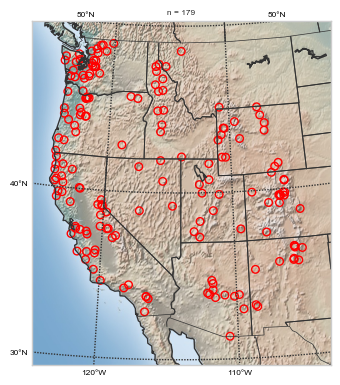

In [7]:
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

## Standardize streamflow

In [8]:
parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.spigamma)
# parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.zscore)

## Basic North Test scree plot

In [9]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 10
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

In [10]:
pc = pd.DataFrame(pc,
                  columns = ['PC' + str(i + 1) for i in range(examine_modes)],
                  index = pd.Index(WY_RANGE, name = 'wy'))

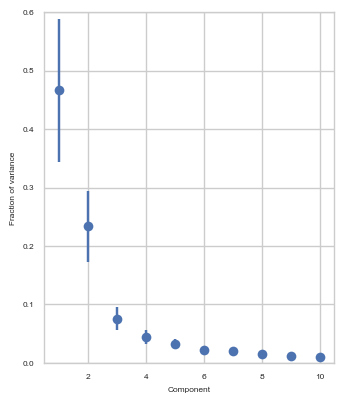

In [11]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [12]:
retain_modes = 2

## PC time series from leading components

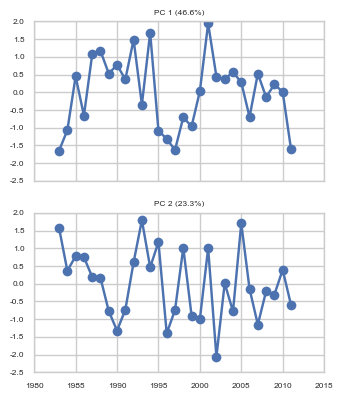

In [13]:
out = tools.plot_pc(solver, yr = WY_RANGE, nmodes = retain_modes)

## Leading EOFs mapped as covariance

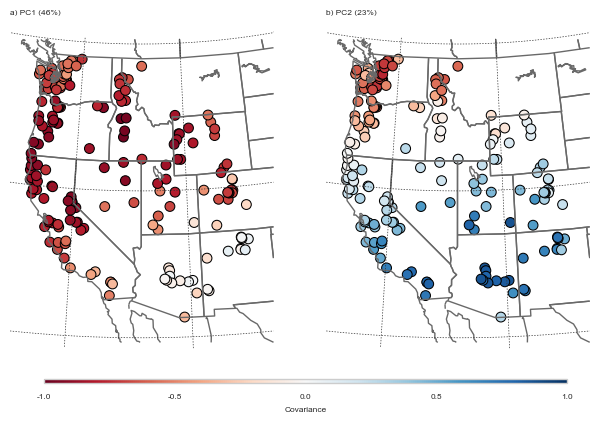

In [14]:
out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes)

# Point correlation & composite maps

In [15]:
with xr.open_dataset(HGT_PATH) as hgt:
    hgt_anom = hgt.z500[np.in1d(hgt['wy'], WY_RANGE)].copy()

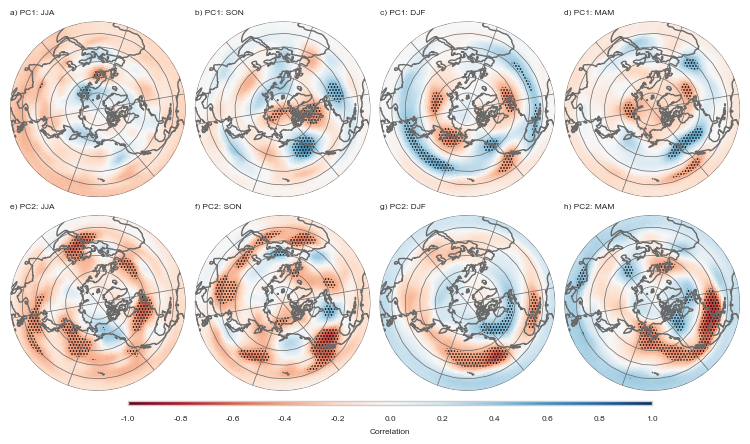

In [18]:
hgt_corrs = tools.pointfield_corr(field = hgt_anom, pc_df = pc)
out = tools.plot_pointfield_corr(hgt_corrs, map_type = 'north_hemisphere')

<xarray.DataArray 'Composite difference (m)' ()>
array(-78.18888888888978)
<xarray.DataArray 'Composite difference (m)' ()>
array(77.56507936507842)


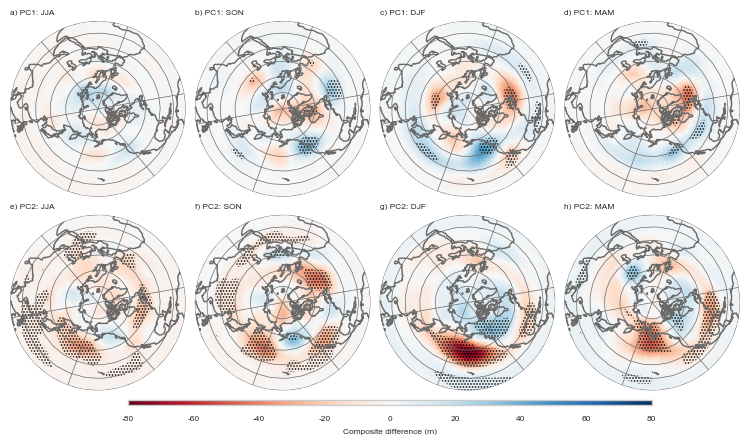

In [19]:
stat_str = 'Composite difference (m)'
hgt_ttest = tools.pointfield_ttest(stat_name = stat_str,
                                   field = hgt_anom, 
                                   pc_df = pc)

out = tools.plot_pointfield_ttest(hgt_ttest, 
                                  map_type = 'north_hemisphere', 
                                  stat_name = stat_str,
                                  vmin = -80, vmax = 80)

print(hgt_ttest[stat_str].min())
print(hgt_ttest[stat_str].max())

In [20]:
with xr.open_dataset(SST_PATH) as ersst:
    sst_anom = ersst.sst[np.in1d(ersst['wy'], WY_RANGE)].copy()

../tools.py:324: RuntimeWarning: invalid value encountered in greater
  r[r > 1] = 1
../tools.py:325: RuntimeWarning: invalid value encountered in less
  r[r < -1] = -1
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
../tools.py:324: RuntimeWarning: invalid value encountered in greater
  r[r > 1] = 1
../tools.py:325: RuntimeWarning: invalid value encountered in less
  r[r < -1] = -1
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
../tools.py:324: RuntimeWarning: invalid value encountered in greater
  r[r > 1] = 1
../tools.py:325: RuntimeWarning: invalid value encountered in less
  r[r < -1] = -1
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: Run

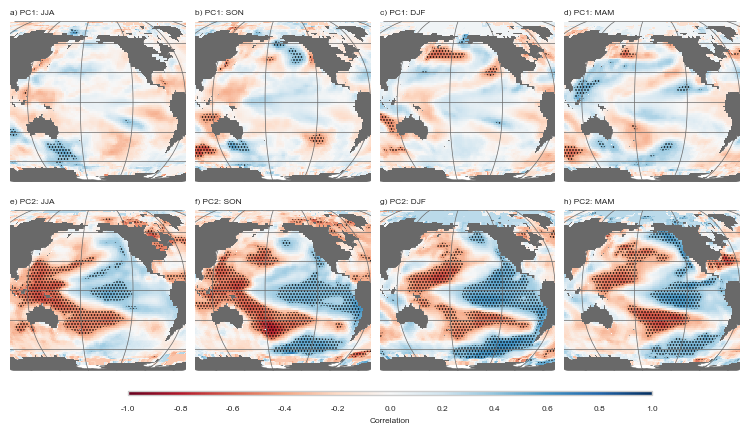

In [21]:
sst_corrs = tools.pointfield_corr(field = sst_anom, pc_df = pc)
out = tools.plot_pointfield_corr(sst_corrs, map_type = 'global')

/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverp

<xarray.DataArray 'Composite difference (°C)' ()>
array(-1.3775482180952245)
<xarray.DataArray 'Composite difference (°C)' ()>
array(1.723311508707818)


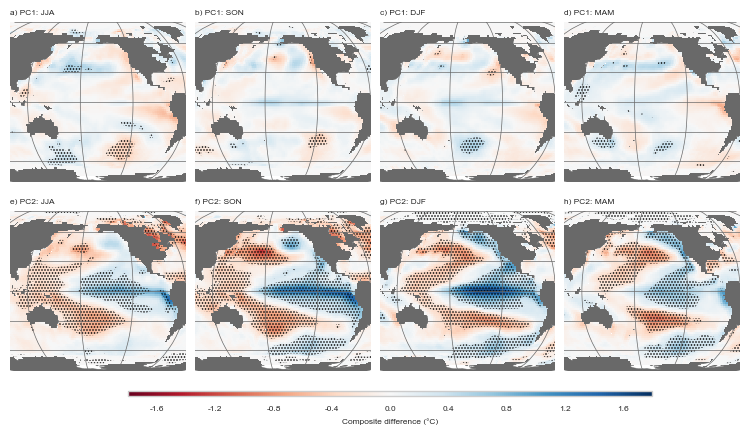

In [24]:
stat_str = 'Composite difference (°C)'
sst_ttest = tools.pointfield_ttest(stat_name = stat_str,
                                   field = sst_anom, 
                                   pc_df = pc)

out = tools.plot_pointfield_ttest(sst_ttest, 
                                  map_type = 'global', 
                                  stat_name = stat_str,
                                  vmin = -1.8, vmax = 1.8)

print(sst_ttest[stat_str].min())
print(sst_ttest[stat_str].max())